# Environment setup

In [1]:
%pwd

'/workspace/GitHub/AVSL/models'

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

True
11.3


In [3]:
import os
print(os.environ.get('CUDA_PATH'))

None


In [4]:
# ! python -m pip install detectron2 -f \
#   https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html

In [ ]:
# ! python -m pip install git+https://github.com/facebookresearch/detectron2.git

# ! git clone git@github.com:facebookresearch/detectron2.git
# ! git clone https://github.com/facebookresearch/detectron2.git
# %cd detectron2
# ! pip install -e .
# %cd ..

In [ ]:
# ! pip install git+https://github.com/cocodataset/panopticapi.git
# ! pip install git+https://github.com/mcordts/cityscapesScripts.git

In [ ]:
# ! git clone https://github.com/facebookresearch/Mask2Former.git
# %cd /workspace/GitHub/AVSL/models/Mask2former
# ! pip install -r requirements.txt

In [7]:
from torch.utils.cpp_extension import CUDA_HOME
print(CUDA_HOME)

None


In [27]:
# %cd mask2former/modeling/pixel_decoder/ops
! sh make.sh
! pip install -e .
# %cd ../../../../

: not found make.sh: 
: not found: make.sh: 


Traceback (most recent call last):
  File "setup.py", line 76, in <module>
    ext_modules=get_extensions(),
  File "setup.py", line 52, in get_extensions
    raise NotImplementedError('CUDA_HOME is None. Please set environment variable CUDA_HOME.')
NotImplementedError: CUDA_HOME is None. Please set environment variable CUDA_HOME.
Obtaining file:///workspace/GitHub/AVSL/models/Mask2former/maskformer/modeling/pixel_decoder/ops
    ERROR: Command errored out with exit status 1:
     command: /opt/conda/envs/GEA/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/workspace/GitHub/AVSL/models/Mask2former/maskformer/modeling/pixel_decoder/ops/setup.py'"'"'; __file__='"'"'/workspace/GitHub/AVSL/models/Mask2former/maskformer/modeling/pixel_decoder/ops/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-ehlt470_
  

In [1]:
%cd /workspace/GitHub/AVSL/models/Mask2former

/workspace/GitHub/AVSL/models/Mask2former


In [2]:
import detectron2.utils.comm as comm
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.utils.logger import setup_logger

# from mask2former.config import add_maskformer2_config
from mask2former import add_maskformer2_config

- init.py: from . import modeling
- modeling/init.py: from .pixel_decoder.msdeformattn import MSDeformAttnPixelDecoder
- modeling/pixel_decoder/msdeformattn.py: from .ops.modules import MSDeformAttn
- modeling/pixel_decoder/ops/modules/ms_deform_attn.py: from ..functions import MSDeformAttnFunction
- modeling/pixel_decoder/ops/functions/ms_deform_attn_func.py: import MultiScaleDeformableAttention as MSDA 주석 처리

In [3]:
# Create configs and perform basic setups

cfg = get_cfg()
# for poly lr schedule
add_deeplab_config(cfg)
add_maskformer2_config(cfg)
cfg.merge_from_file("configs/custom/MaskAVSL_swin_large.yaml")
# cfg.merge_from_list(args.opts)
cfg.MODEL.DEVICE = "cuda:1"
cfg.eval_only = True
cfg.freeze()
# default_setup(cfg, args)
# Setup logger for "mask_former" module
setup_logger(output=cfg.OUTPUT_DIR, distributed_rank=comm.get_rank(), name="mask2former")

<Logger mask2former (DEBUG)>

# Custom Dataset

In [4]:
import sys, os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from moviepy.editor import VideoFileClip

from detectron2.config import configurable
from detectron2.data import transforms as T
from detectron2.projects.point_rend import ColorAugSSDTransform
from detectron2.data import detection_utils as utils

In [5]:
class VideoDataset(Dataset):
    @configurable
    def __init__(self, is_train=True, *, augmentations, image_format, ignore_label, size_divisibility, folder_path, ):
        self.folder_path = folder_path
        self.video_list = [f for f in os.listdir(folder_path) if f.endswith('.mp4')]
        self.tfm_gens = augmentations

        self.is_train = is_train
        self.img_format = image_format
        self.ignore_label = ignore_label
        self.size_divisibility = size_divisibility

    def __len__(self):
        return len(self.video_list)

    def __getitem__(self, idx):
        video_path = os.path.join(self.folder_path, self.video_list[idx])

        # Load video and extract central frame
        video_clip = VideoFileClip(video_path)
        central_frame = video_clip.get_frame(video_clip.duration / 2)
        central_frame = np.array(central_frame)
        # Convert image frame to numpy array and normalize
        #central_frame = central_frame / 255.0

        # Additional augmentation
        aug_input = T.AugInput(central_frame)
        aug_input, transforms = T.apply_transform_gens(self.tfm_gens, aug_input)
        central_frame = aug_input.image
        #sem_seg_gt = aug_input.sem_seg

        central_frame = torch.as_tensor(np.ascontiguousarray(central_frame.transpose(2, 0, 1)))
        #central_frame = np.transpose(central_frame, (2, 0, 1))  # Change HWC to CHW

        if self.size_divisibility > 0:
            central_frame_size = (central_frame.shape[-2], central_frame.shape[-1])
            padding_size = [
                0,
                self.size_divisibility - central_frame_size[1],
                0,
                self.size_divisibility - central_frame_size[0],
            ]
            central_frame = F.pad(central_frame, padding_size, value=128).contiguous()

        sample = {}
        # sample['image'] = central_frame

        # Save audio as WAV file
        audio_path = f"{video_path[:-4]}.wav"
        self.blockPrint()
        video_clip.audio.write_audiofile(audio_path, codec='pcm_s16le', fps=44100)
        self.enablePrint()

        # Return data as dictionary
        sample = {'image': central_frame, 'audio_path': audio_path}

        return sample

    @classmethod
    def from_config(cls, cfg, is_train=True):
        # Build augmentation
        augs = [
            T.ResizeShortestEdge(
                cfg.INPUT.MIN_SIZE_TRAIN,
                cfg.INPUT.MAX_SIZE_TRAIN,
                cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING,
            )
        ]
        if cfg.INPUT.CROP.ENABLED:
            augs.append(
                T.RandomCrop_CategoryAreaConstraint(
                    cfg.INPUT.CROP.TYPE,
                    cfg.INPUT.CROP.SIZE,
                    cfg.INPUT.CROP.SINGLE_CATEGORY_MAX_AREA,
                    cfg.MODEL.SEM_SEG_HEAD.IGNORE_VALUE,
                )
            )
        if cfg.INPUT.COLOR_AUG_SSD:
            augs.append(ColorAugSSDTransform(img_format=cfg.INPUT.FORMAT))
        augs.append(T.RandomFlip())
        augs.extend([
        T.ResizeScale(
            min_scale=cfg.INPUT.MIN_SCALE, max_scale=cfg.INPUT.MAX_SCALE,
            target_height=cfg.INPUT.IMAGE_SIZE, target_width=cfg.INPUT.IMAGE_SIZE
        ),
        T.FixedSizeCrop(crop_size=(cfg.INPUT.IMAGE_SIZE, cfg.INPUT.IMAGE_SIZE)),
        ])

        ignore_label = False

        ret = {
            "is_train": is_train,
            "augmentations": augs,
            "image_format": cfg.INPUT.FORMAT,
            "ignore_label": ignore_label,
            "size_divisibility": cfg.INPUT.SIZE_DIVISIBILITY,
        }
        return ret
    
    def blockPrint(self):
        global backupstdout
        backupstdout=sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def enablePrint(self):
        global backupstdout
        sys.stdout = backupstdout

In [6]:
%cd /workspace/GitHub/AVSL

/workspace/GitHub/AVSL


In [7]:
folder_path = 'DATA/videos'
video_dataset = VideoDataset(cfg, folder_path=folder_path)
dataloader = DataLoader(video_dataset, batch_size=cfg.SOLVER.IMS_PER_BATCH, shuffle=True)

In [8]:
print(len(video_dataset))
print(len(dataloader))

18967
1186


In [9]:
# detectron2/engine/train_loop.py

data = next(iter(dataloader))

In [10]:
data['image'].shape

torch.Size([16, 3, 1024, 1024])

In [44]:
example = video_dataset.__getitem__(1)
print(example.keys())

dict_keys(['image', 'audio_path'])


In [15]:
example['image'].shape

torch.Size([3, 1024, 1024])

In [16]:
example['audio_path']

'DATA/videos/6078.wav'

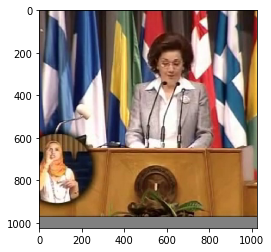

In [17]:
from matplotlib import pyplot as plt
plt.imshow(example['image'].permute(1, 2, 0), interpolation='nearest')
plt.show()

44100 (441882, 2)


(0.0, 441882.0)

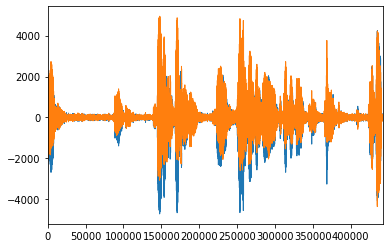

In [18]:
from scipy.io import wavfile

fs, audio_data = wavfile.read(example['audio_path'])
print(fs, audio_data.shape)

# plt.figure(figsize = (12, 3))
plt.plot(audio_data, lw = 1)
plt.xlim(0, len(audio_data))

In [11]:
# maskformer_model.py
from detectron2.structures import ImageList
from tqdm import tqdm

pixel_mean = cfg.MODEL.PIXEL_MEAN
pixel_std = cfg.MODEL.PIXEL_STD
size_divisibility = cfg.MODEL.MASK_FORMER.SIZE_DIVISIBILITY
device = cfg.MODEL.DEVICE

pixel_mean = torch.Tensor(pixel_mean).view(-1, 1, 1)
pixel_std = torch.Tensor(pixel_std).view(-1, 1, 1)

# images = [x["image"].to(device) for x in tqdm(data)] # 한 batch 당 대략 15초 걸림
# images = [(x - pixel_mean) / pixel_std for x in tqdm(images)]
# images = ImageList.from_tensors(images, size_divisibility)

images = []
for i, x in tqdm(enumerate(dataloader)): 
    img = x["image"]
    img = (img - pixel_mean) / pixel_std
    images.append(img)
    if i == 10:
        break # 11개에 2분

10it [02:31, 15.13s/it]


In [12]:
images = ImageList.from_tensors(images, size_divisibility)

In [13]:
images.to(device)

# Model Architecture

## backbone

In [14]:
%cd /workspace/GitHub/AVSL/models/Mask2former

/workspace/GitHub/AVSL/models/Mask2former


In [15]:
# from detectron2.modeling import build_backbone

# backbone = build_backbone(cfg)
# backbone = BACKBONE_REGISTRY.get(backbone_name)(cfg, input_shape)

In [16]:
from detectron2.layers import ShapeSpec
from mask2former.modeling.backbone.swin import D2SwinTransformer

print(cfg.MODEL.WEIGHTS)
input_shape = ShapeSpec(channels=len(cfg.MODEL.PIXEL_MEAN))
backbone = D2SwinTransformer(cfg, input_shape)

swin_large_patch4_window12_384_22k.pth


In [17]:
backbone.init_weights(cfg.MODEL.WEIGHTS)

In [18]:
len(images.tensor)

11

In [19]:
features = backbone(images.tensor[0])

In [20]:
features.keys()

dict_keys(['res2', 'res3', 'res4', 'res5'])

In [19]:
print(features['res2'].shape)
print(features['res3'].shape)
print(features['res4'].shape)
print(features['res5'].shape)

torch.Size([16, 192, 256, 256])
torch.Size([16, 384, 128, 128])
torch.Size([16, 768, 64, 64])
torch.Size([16, 1536, 32, 32])


## pixel_decoder

In [ ]:
# from detectron2.modeling import build_sem_seg_head

# sem_seg_head = build_sem_seg_head(cfg, backbone.output_shape())
# -> SEM_SEG_HEADS_REGISTRY.get(name)(cfg, input_shape)

In [ ]:
# from mask2former.maskformer_model.modeling.pixel_decoder.fpn import build_pixel_decoder

# build_pixel_decoder(cfg, input_shape)
# -> model = SEM_SEG_HEADS_REGISTRY.get(name)(cfg, input_shape)

In [21]:
backbone.output_shape()

{'res2': ShapeSpec(channels=192, height=None, width=None, stride=4),
 'res3': ShapeSpec(channels=384, height=None, width=None, stride=8),
 'res4': ShapeSpec(channels=768, height=None, width=None, stride=16),
 'res5': ShapeSpec(channels=1536, height=None, width=None, stride=32)}

In [21]:
from mask2former.modeling.pixel_decoder.fpn import TransformerEncoderPixelDecoder

pixel_decoder = TransformerEncoderPixelDecoder(cfg, input_shape=backbone.output_shape()) # maskformer_model.py

In [22]:
# mask_foremer_head.py
mask_features, transformer_encoder_features, multi_scale_features = pixel_decoder.forward_features(features)

In [23]:
transformer_encoder_features.shape

torch.Size([16, 256, 32, 32])

In [40]:
for i in range(len(multi_scale_features)):
    print(multi_scale_features[i].shape)

torch.Size([16, 256, 32, 32])
torch.Size([16, 256, 64, 64])
torch.Size([16, 256, 128, 128])


## transformer decoder

In [24]:
# mask_former_head.py
if cfg.MODEL.MASK_FORMER.TRANSFORMER_IN_FEATURE == "transformer_encoder":
    transformer_predictor_in_channels = cfg.MODEL.SEM_SEG_HEAD.CONVS_DIM
elif cfg.MODEL.MASK_FORMER.TRANSFORMER_IN_FEATURE == "pixel_embedding":
    transformer_predictor_in_channels = cfg.MODEL.SEM_SEG_HEAD.MASK_DIM
elif cfg.MODEL.MASK_FORMER.TRANSFORMER_IN_FEATURE == "multi_scale_pixel_decoder":  # for maskformer2
    transformer_predictor_in_channels = cfg.MODEL.SEM_SEG_HEAD.CONVS_DIM
else:
    transformer_predictor_in_channels = input_shape[cfg.MODEL.MASK_FORMER.TRANSFORMER_IN_FEATURE].channels

# "transformer_predictor": build_transformer_decoder(cfg, transformer_predictor_in_channels, mask_classification=True,)
# -> TRANSFORMER_DECODER_REGISTRY.get(name)(cfg, in_channels, mask_classification)

In [25]:
from mask2former.modeling.transformer_decoder.maskformer_transformer_decoder import StandardTransformerDecoder

transformer_decoder = StandardTransformerDecoder(cfg, in_channels=transformer_predictor_in_channels, mask_classification=False)

In [26]:
# mask_former_head.py
predictions = transformer_decoder(transformer_encoder_features, mask_features, mask=None) # mask에 뭐가 들어가야 하는지 모르겠다

In [52]:
predictions.keys()

dict_keys(['pred_masks', 'aux_outputs'])

In [55]:
predictions['pred_masks'].shape # scoremap
predictions['pred_masks']

tensor([[[[ 3.8857e-01,  8.7469e-01,  8.7175e-01,  ...,  7.8186e-01,
            9.8901e-01,  1.0366e+00],
          [ 3.6404e-01,  4.1569e-01,  3.2601e-03,  ..., -1.3654e-01,
           -3.4956e-01,  5.5323e-01],
          [-1.0352e-01,  1.7415e-01, -2.5161e-01,  ..., -1.5683e-01,
            2.1336e-01,  9.6119e-01],
          ...,
          [-1.5146e+00, -1.7745e+00, -2.2045e+00,  ..., -2.0534e+00,
           -1.8727e+00, -1.1401e+00],
          [-2.0824e+00, -2.3311e+00, -2.2867e+00,  ..., -2.2380e+00,
           -2.0224e+00, -1.0116e+00],
          [-1.3498e+00, -1.4276e+00, -1.7869e+00,  ..., -1.3895e+00,
           -1.4598e+00, -8.3899e-01]],

         [[ 3.7075e-01,  8.5379e-01,  8.4619e-01,  ...,  7.7313e-01,
            9.8601e-01,  1.0113e+00],
          [ 3.5555e-01,  4.1120e-01,  6.8743e-03,  ..., -1.2030e-01,
           -3.3115e-01,  5.2844e-01],
          [-1.0734e-01,  1.9553e-01, -2.3153e-01,  ..., -1.3895e-01,
            2.2894e-01,  9.3763e-01],
          ...,
     

In [58]:
print(predictions['pred_masks'].min())
print(predictions['pred_masks'].max())
# 음수 값이 나오는 것을 방지하기 위해 sigmoid 함수 고려

tensor(-7.4014, grad_fn=<MinBackward1>)
tensor(4.2669, grad_fn=<MaxBackward1>)


## transformer decoder 수정

In [27]:
# maskformer_transformer_decoder_custom.py
from mask2former.modeling.transformer_decoder.transformer import Transformer
from mask2former.modeling.transformer_decoder.position_encoding import PositionEmbeddingSine
from torch import nn

N_steps = cfg.MODEL.MASK_FORMER.HIDDEN_DIM // 2
pe_layer = PositionEmbeddingSine(N_steps, normalize=True)

num_queries = cfg.MODEL.MASK_FORMER.NUM_OBJECT_QUERIES
transformer = Transformer(
            d_model=cfg.MODEL.MASK_FORMER.HIDDEN_DIM,
            dropout=cfg.MODEL.MASK_FORMER.DROPOUT,
            nhead=cfg.MODEL.MASK_FORMER.NHEADS,
            dim_feedforward=cfg.MODEL.MASK_FORMER.DIM_FEEDFORWARD,
            num_encoder_layers=cfg.MODEL.MASK_FORMER.ENC_LAYERS,
            num_decoder_layers=cfg.MODEL.MASK_FORMER.DEC_LAYERS,
            normalize_before=cfg.MODEL.MASK_FORMER.PRE_NORM,
            return_intermediate_dec=cfg.MODEL.MASK_FORMER.DEEP_SUPERVISION,
        )
hidden_dim = transformer.d_model

In [28]:
import fvcore.nn.weight_init as weight_init
from detectron2.layers import Conv2d
from mask2former.modeling.transformer_decoder.maskformer_transformer_decoder_custom import MLP

query_embed = nn.Embedding(num_queries, hidden_dim)

in_channels = transformer_predictor_in_channels # mask_former_head.py
enforce_input_project = cfg.MODEL.MASK_FORMER.ENFORCE_INPUT_PROJ
deep_supervision = cfg.MODEL.MASK_FORMER.DEEP_SUPERVISION
mask_dim = cfg.MODEL.SEM_SEG_HEAD.MASK_DIM

if in_channels != hidden_dim or enforce_input_project:
    input_proj = Conv2d(in_channels, hidden_dim, kernel_size=1)
    weight_init.c2_xavier_fill(input_proj)
else:
    input_proj = nn.Sequential()
aux_loss = deep_supervision

mask_embed = MLP(hidden_dim, hidden_dim, mask_dim, 3)

In [29]:
x = transformer_encoder_features

In [30]:
mask = None

pos = pe_layer(x, mask)

src = x
hs, memory = transformer(input_proj(src), mask, query_embed.weight, pos)

In [45]:
transformer(input_proj(src), mask, query_embed.weight, pos)

(tensor([[[[ 9.8731e-01, -6.8423e-01, -2.2815e-01,  ...,  4.7642e-01,
             7.9717e-01, -5.4457e-02],
           [ 9.5747e-01, -6.7368e-01, -2.1269e-01,  ...,  4.8045e-01,
             7.7649e-01, -2.5572e-02],
           [ 9.8167e-01, -6.7425e-01, -2.0912e-01,  ...,  5.1657e-01,
             7.9821e-01,  3.6860e-03],
           ...,
           [ 9.7256e-01, -6.8686e-01, -1.9517e-01,  ...,  5.4578e-01,
             7.7958e-01,  1.0109e-02],
           [ 1.0122e+00, -6.8958e-01, -2.4142e-01,  ...,  5.1796e-01,
             8.0192e-01, -3.4683e-02],
           [ 1.0054e+00, -6.8113e-01, -2.2319e-01,  ...,  4.9295e-01,
             8.0725e-01, -1.6277e-02]],
 
          [[ 4.9354e-01,  1.3254e-01,  1.6524e-01,  ...,  2.6298e-01,
             8.2088e-01,  1.7767e+00],
           [ 4.9218e-01,  1.3406e-01,  1.5147e-01,  ...,  2.4663e-01,
             7.7698e-01,  1.7501e+00],
           [ 4.9119e-01,  8.9456e-02,  1.5051e-01,  ...,  2.7773e-01,
             8.5759e-01,  1.7828e+00],


In [36]:
hs.shape

torch.Size([10, 16, 100, 128])

In [34]:
def audio_module(mixed_audio, query_output, noise_query, batch_size):
    query_input = torch.cat([query_output, noise_query], dim=1)
    out = torch.rand(batch_size, num_queries, 903, hidden_dim)
    return out

def av_feature_embed(av_feature, pooling_mode='sum'):
    if pooling_mode == 'sum':
        av_feature = av_feature.sum(dim=2)
    elif pooling_mode == 'mean':
        av_feature = av_feature.mean(dim=2)
    elif pooling_mode == 'max':
        av_feature = av_feature.max(dim=2).values
    return av_feature

In [40]:
batch_size=cfg.SOLVER.IMS_PER_BATCH

noise_query = torch.rand(batch_size, 1, hidden_dim)
# av_feature = audio_module(None, hs, noise_query, batch_size)

In [41]:
noise_query.shape

torch.Size([16, 1, 128])

In [32]:
noise_query = torch.rand(1, 1, hidden_dim)
av_feature = audio_module(None, query_output, noise_query, bs)
av_feature = av_feature_embed(av_feature)

torch.Size([16, 100, 128])

In [50]:
mask_cls_results = outputs["pred_logits"]
mask_pred_results = outputs["pred_masks"]

print(mask_pred_results.shape)

torch.Size([1, 100, 256, 256])


In [51]:
mask_pred_results = F.interpolate(
                mask_pred_results,
                size=(images.tensor.shape[-2], images.tensor.shape[-1]),
                mode="bilinear",
                align_corners=False,
            )

In [52]:
image_size = images.image_sizes

In [65]:
def semantic_inference(mask_cls, mask_pred):
    mask_cls = F.softmax(mask_cls, dim=-1)[..., :-1]
    mask_pred = mask_pred.sigmoid()
    semseg = torch.einsum("qc,qhw->chw", mask_cls, mask_pred)
    return semseg

def panoptic_inference(mask_cls, mask_pred):
    scores, labels = F.softmax(mask_cls, dim=-1).max(-1)
    mask_pred = mask_pred.sigmoid()

    keep = labels.ne(sem_seg_head.num_classes) & (scores > object_mask_threshold)
    cur_scores = scores[keep]
    cur_classes = labels[keep]
    cur_masks = mask_pred[keep]
    cur_mask_cls = mask_cls[keep]
    cur_mask_cls = cur_mask_cls[:, :-1]

    cur_prob_masks = cur_scores.view(-1, 1, 1) * cur_masks

    h, w = cur_masks.shape[-2:]
    panoptic_seg = torch.zeros((h, w), dtype=torch.int32, device=cur_masks.device)
    segments_info = []

    current_segment_id = 0

    if cur_masks.shape[0] == 0:
        # We didn't detect any mask :(
        return panoptic_seg, segments_info
    else:
        # take argmax
        cur_mask_ids = cur_prob_masks.argmax(0)
        stuff_memory_list = {}
        for k in range(cur_classes.shape[0]):
            pred_class = cur_classes[k].item()
            isthing = pred_class in metadata.thing_dataset_id_to_contiguous_id.values()
            mask_area = (cur_mask_ids == k).sum().item()
            original_area = (cur_masks[k] >= 0.5).sum().item()
            mask = (cur_mask_ids == k) & (cur_masks[k] >= 0.5)

            if mask_area > 0 and original_area > 0 and mask.sum().item() > 0:
                if mask_area / original_area < overlap_threshold:
                    continue

                # merge stuff regions
                if not isthing:
                    if int(pred_class) in stuff_memory_list.keys():
                        panoptic_seg[mask] = stuff_memory_list[int(pred_class)]
                        continue
                    else:
                        stuff_memory_list[int(pred_class)] = current_segment_id + 1

                current_segment_id += 1
                panoptic_seg[mask] = current_segment_id

                segments_info.append(
                    {
                        "id": current_segment_id,
                        "isthing": bool(isthing),
                        "category_id": int(pred_class),
                    }
                )

        return panoptic_seg, segments_info

def instance_inference(mask_cls, mask_pred):
    # mask_pred is already processed to have the same shape as original input
    image_size = mask_pred.shape[-2:]

    # [Q, K]
    scores = F.softmax(mask_cls, dim=-1)[:, :-1]
    labels = torch.arange(sem_seg_head.num_classes, device=device).unsqueeze(0).repeat(num_queries, 1).flatten(0, 1)
    # scores_per_image, topk_indices = scores.flatten(0, 1).topk(num_queries, sorted=False)
    scores_per_image, topk_indices = scores.flatten(0, 1).topk(test_topk_per_image, sorted=False)
    labels_per_image = labels[topk_indices]

    topk_indices = topk_indices // sem_seg_head.num_classes
    # mask_pred = mask_pred.unsqueeze(1).repeat(1, sem_seg_head.num_classes, 1).flatten(0, 1)
    mask_pred = mask_pred[topk_indices]

    # if this is panoptic segmentation, we only keep the "thing" classes
    if panoptic_on:
        keep = torch.zeros_like(scores_per_image).bool()
        for i, lab in enumerate(labels_per_image):
            keep[i] = lab in metadata.thing_dataset_id_to_contiguous_id.values()

        scores_per_image = scores_per_image[keep]
        labels_per_image = labels_per_image[keep]
        mask_pred = mask_pred[keep]

    result = Instances(image_size)
    # mask (before sigmoid)
    result.pred_masks = (mask_pred > 0).float()
    result.pred_boxes = Boxes(torch.zeros(mask_pred.size(0), 4))
    # Uncomment the following to get boxes from masks (this is slow)
    # result.pred_boxes = BitMasks(mask_pred > 0).get_bounding_boxes()

    # calculate average mask prob
    mask_scores_per_image = (mask_pred.sigmoid().flatten(1) * result.pred_masks.flatten(1)).sum(1) / (result.pred_masks.flatten(1).sum(1) + 1e-6)
    result.scores = scores_per_image * mask_scores_per_image
    result.pred_classes = labels_per_image
    return result

In [66]:
processed_results = []
batched_inputs = dataset_dict["image"]

for mask_cls_result, mask_pred_result, input_per_image, image_size in zip(
    mask_cls_results, mask_pred_results, batched_inputs, images.image_sizes):
    height = 1024 # input_per_image.get("height", image_size[0])
    width = 1024 # input_per_image.get("width", image_size[1])
    processed_results.append({})

    if sem_seg_postprocess_before_inference:
        mask_pred_result = retry_if_cuda_oom(sem_seg_postprocess)(
            mask_pred_result, image_size, height, width
        )
        mask_cls_result = mask_cls_result.to(mask_pred_result)

    # semantic segmentation inference
    if semantic_on:
        r = retry_if_cuda_oom(semantic_inference)(mask_cls_result, mask_pred_result)
        if not sem_seg_postprocess_before_inference:
            r = retry_if_cuda_oom(sem_seg_postprocess)(r, image_size, height, width)
        processed_results[-1]["sem_seg"] = r

    # panoptic segmentation inference
    if panoptic_on:
        panoptic_r = retry_if_cuda_oom(panoptic_inference)(mask_cls_result, mask_pred_result)
        processed_results[-1]["panoptic_seg"] = panoptic_r

    # instance segmentation inference
    if instance_on:
        instance_r = retry_if_cuda_oom(instance_inference)(mask_cls_result, mask_pred_result)
        processed_results[-1]["instances"] = instance_r


In [72]:
processed_results[0].keys()

dict_keys(['sem_seg', 'panoptic_seg', 'instances'])

In [74]:
processed_results[0]['sem_seg'].shape

torch.Size([133, 1024, 1024])